In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()
import logging
import sys
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.info("Hello world")

INFO:root:Hello world


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.exposure import equalize_hist
from PIL import Image
import pickle
import time
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


### Overview of Style Transfer
Style transfer algorithms are a popular technique in computer vision and image processing that aim to apply the artistic style of one image to another while preserving the content. There are several style transfer algorithms, but one of the most well-known and widely used approaches is the Neural Style Transfer (NST) algorithm, which was introduced by Gatys et al. in 2015.

The Neural Style Transfer algorithm utilizes deep convolutional neural networks (CNNs) to extract features from both the style image and the content image. The idea is to define a loss function that captures the content similarity between the content image and the generated image, as well as the style similarity between the style image and the generated image.

Here's a high-level overview of the Neural Style Transfer algorithm:

1. Preprocessing:
   - The content image and the style image are resized to a desired size.
   - The images are then normalized to have zero mean and unit variance.

2. Choose a pre-trained CNN:
   - Typically, a pre-trained CNN model such as VGG (Visual Geometry Group) is used.
   - The CNN model is used to extract features from different layers.

3. Define the loss function:
   - The content loss measures the similarity between the content image and the generated image at a certain layer of the CNN.
   - The style loss measures the similarity between the style image and the generated image at multiple layers of the CNN.
   - The total loss is a weighted combination of the content loss and the style loss.

4. Optimization:
   - An optimization process is performed to minimize the total loss.
   - The generated image is iteratively updated by adjusting its pixel values.
   - The optimization process can use gradient descent algorithms to find the optimal image that minimizes the loss function.

5. Postprocessing:
   - Once the optimization process is complete, the generated image can be postprocessed.
   - This may involve adjusting the color balance, contrast, or other aspects to enhance the visual quality.

The Neural Style Transfer algorithm has been extended and modified in various ways since its original proposal, incorporating techniques such as instance normalization, multi-scale style transfer, and adversarial training to improve the quality and efficiency of style transfer.

It's worth noting that there are other style transfer algorithms besides Neural Style Transfer, such as Fast Style Transfer, which introduces a feed-forward neural network to achieve real-time style transfer. Additionally, newer methods based on generative adversarial networks (GANs) have also been proposed, enabling more advanced and diverse style transfer capabilities.

### Load Image

In [ ]:
# Show image
def imshow(image, title=None):
    if(len(image.shape) > 3):
        image=np.squeeze(image, axis=0)
    plt.imshow(image)
    if(title):
        plt.title(title)

In [ ]:

# Define a function to load an image and limit its maximum dimension to 512 pixels.
def load_image(image_path):
    max_dim=512
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    # broadcasting the image array so that it has a batch dimension
    img = img[tf.newaxis, :]

    return img

<Figure size 1200x1200 with 0 Axes>

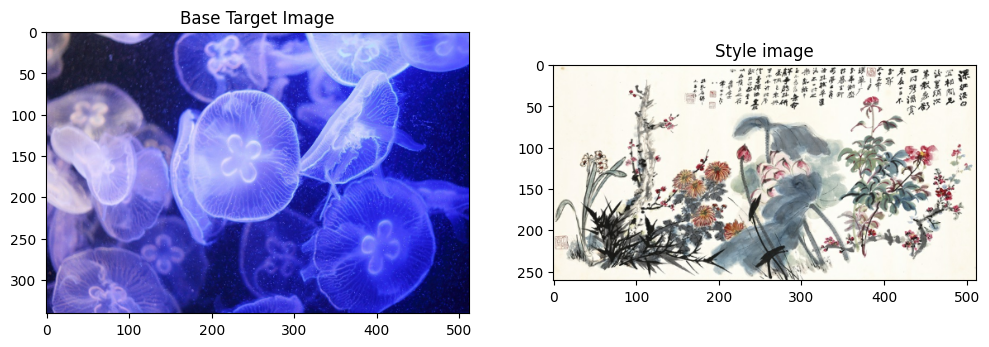

In [ ]:
# image to transfer and style image
content_img=load_image('/content/drive/MyDrive/style/jellyfish_blue.jpeg')
style_img=load_image('/content/drive/MyDrive/style/chinese.jpeg')

# Create a figure with a 2x3 grid
fig = plt.figure(figsize=(12, 12))

plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
imshow(content_img, 'Base Target Image')
plt.subplot(1, 2, 2)
imshow(style_img, 'Style image')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

### Load image recognition model
- Our Neural Style Transfer algorithm utilizes deep convolutional neural networks (CNNs) to extract features from both the style image and the content image.
- Specifically, we use VGG19 to extract style and content image features

In [ ]:
# VGG19 model needs preprocessing for initialization
x=tf.keras.applications.vgg19.preprocess_input(content_img*255)
# VGG19 model takes images in 256*256 dimensions
x=tf.image.resize(x, (256,256))

# Load VGG19 and freeze all layers
vgg_model=tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg_model.trainable=False
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Choose style and content layers
- Use the intermediate layers of the model to get the content and style representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As we step through the network, the final few layers represent higher-level features—object parts like wheels or eyes. In this case, we are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.
- At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

- This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.



In [ ]:
content_layers=['block4_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

In [ ]:
# Build the style transfer model
def my_model(layer_names):
    # Retrieve the output layers corresponding to the content and style layers
    vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg_model.trainable = False
    outputs = [vgg_model.get_layer(name).output for name in layer_names]
    model=tf.keras.Model([vgg_model.input], outputs)
    return model

In [ ]:
style_extractor = my_model(style_layers)
style_outputs = style_extractor(style_img*255)

### Calculate style
- The content of an image is represented by the values of the intermediate feature maps.
- It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations.
- This can be implemented concisely using the tf.linalg.einsum function

In [ ]:
# Compute the gram matrix
# Einsum allows defining Tensors by defining their element-wise computation.
def gram_matrix(input_tensor):
    # input_tensor is of shape channels, Height, Width
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    # Unrolls Height and Width
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

### Build Final Model


In [ ]:
# Returns a dict of dicts with content and style representations
# i.e., gram matrix of the style_layers and the content of the content_layers
class entire_model(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(entire_model, self).__init__()
        self.vgg=my_model(style_layers + content_layers)
        self.style_layers=style_layers
        self.content_layers=content_layers
        self.num_style_layers=len(style_layers)
        self.vgg.trainable=False

    def call(self, inputs):
        # Scale back the pixel values
        inputs=inputs*255.0
        preprocessed_input=tf.keras.applications.vgg19.preprocess_input(inputs)
        # Pass the preprocessed input to my_model
        outputs=self.vgg(preprocessed_input)

        # Separate the representations of style and content
        style_outputs, content_outputs=(outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        # Calculate the gram matrix for each layer in the style output.
        # This will be the final style representation
        style_outputs=[gram_matrix(layer) for layer in style_outputs]

        # Store the content and style representation in dictionaries in a layer by layer manner
        content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [ ]:
# Extract the style and content features by calling the above class
extractor=entire_model(style_layers, content_layers)

style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

In [ ]:
# Custom weights for different style layers
style_weights = {'block1_conv1': 0.7,
                 'block2_conv1': 0.19,
                 'block3_conv1': 0.24,
                 'block4_conv1': 0.11,
                 'block5_conv1': 0.26}

### Run gradient descent
- Build the loss function by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.
- Create an optimizer. The paper recommends LBFGS, but Adam also works.
- To optimize this, use a weighted combination of the two losses to get the total loss.

In [ ]:
# Loss function that captures the content similarity between the content image and the generated image
def total_cost(outputs, style_weight=40, content_weight=10):
    style_outputs=outputs['style']
    content_outputs=outputs['content']
    style_loss=tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                        for name in style_outputs.keys()])
    # Normalize
    style_loss*=style_weight/len(style_layers)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss*=content_weight/len(content_layers)
    loss=style_loss+content_loss
    return loss

In [ ]:
# Define a tf.Variable to contain the image to optimize
generate_image = tf.Variable(content_img)
# Since this is a float image, define a function to keep the pixel values between 0 and 1
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
# Define the optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = total_cost(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

### Train Model

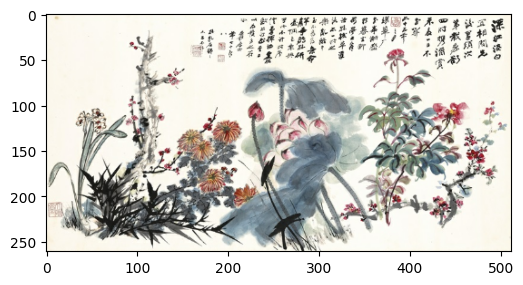

In [ ]:
plt.figure(figsize=(6,6))
imshow(load_image("/content/drive/MyDrive/style/chinese.jpeg"))
plt.savefig("/content/drive/MyDrive/style/orginal.jpeg")

Tensor("AddN:0", shape=(), dtype=float32)
Tensor("Mean_5:0", shape=(), dtype=float32)
Tensor("AddN:0", shape=(), dtype=float32)
Tensor("Mean_5:0", shape=(), dtype=float32)


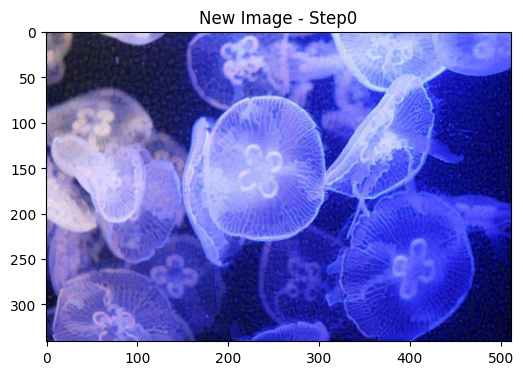

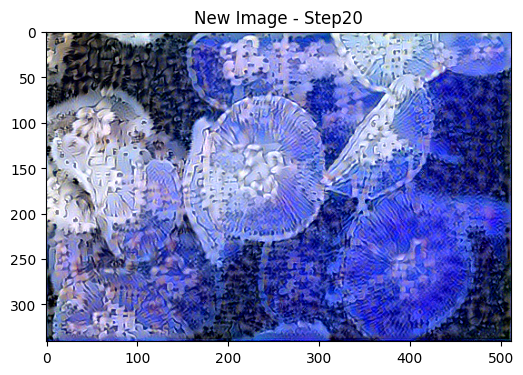

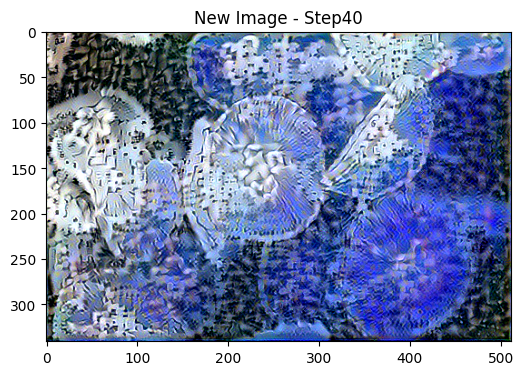

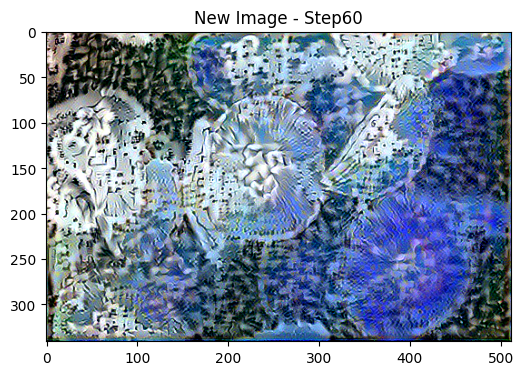

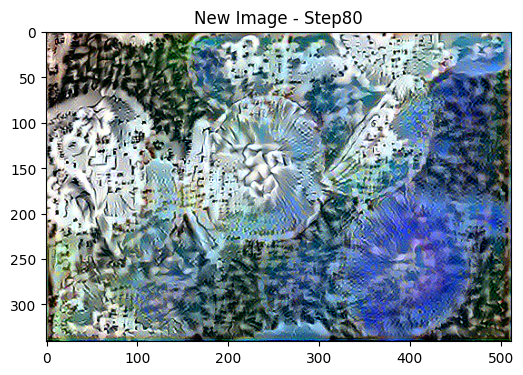

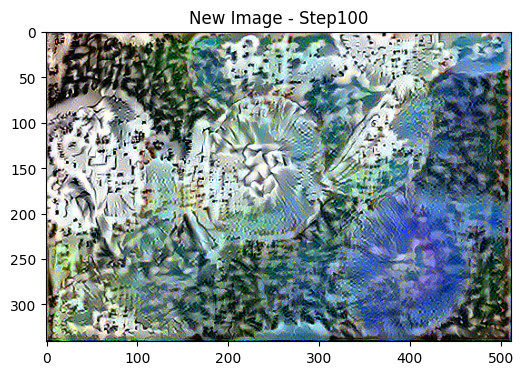

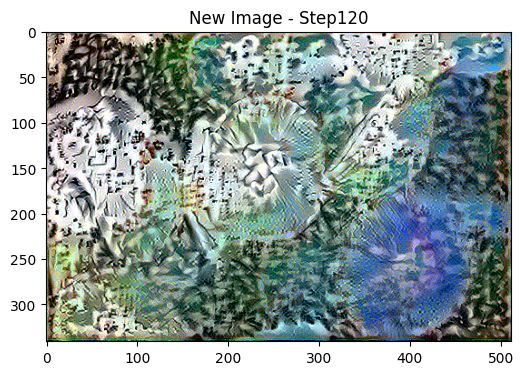

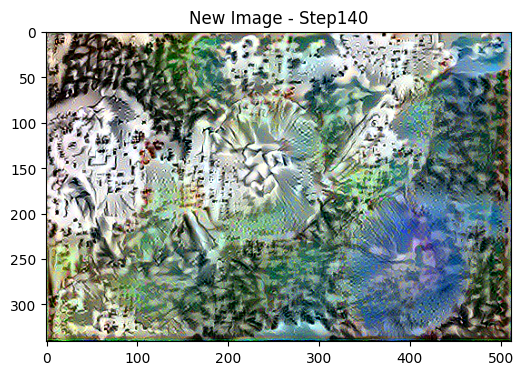

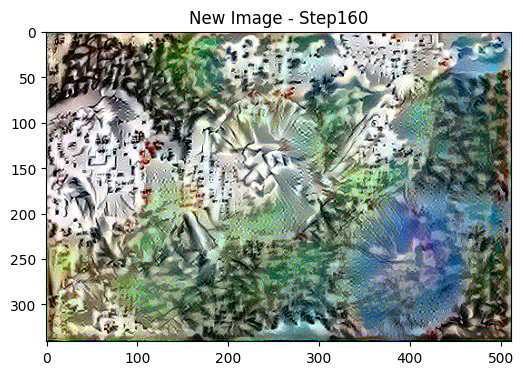

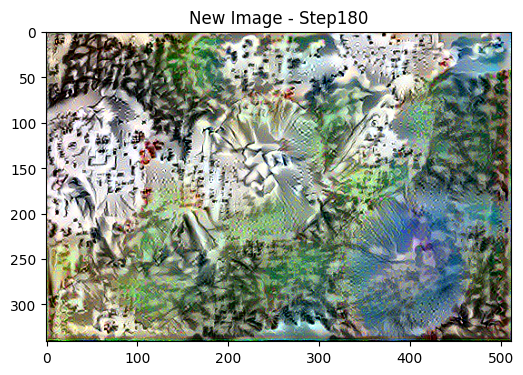

In [ ]:
# train model
num_iterations=200
for i in range(num_iterations):
    train_step(generate_image)
    if(i%20==0):
        plt.figure(figsize=(6,6))
        imshow(np.squeeze(generate_image.read_value(), 0), 'New Image - Step'+str(i))
        plt.savefig("/content/drive/MyDrive/style/image_step%d.jpeg"%(i))

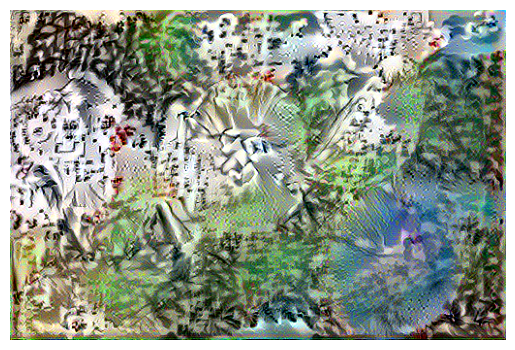

In [ ]:
# show the final style transfer image results
train_step(generate_image)
plt.imshow(np.squeeze(generate_image.read_value(), 0))
plt.axis('off')
fig1 = plt.gcf()

## Evaluation with different content loss and style loss
We also tested with different sets of weights for the combination of content loss and style loss(by manully adjusting the weights assigned) to see how the weights influenced the the visual impact of the final images.


## Style loss

In [ ]:
from tensorflow.keras.applications import VGG16

def gram_matrix(feature):
    # Flatten the feature map
    flattened = tf.reshape(feature, (-1, feature.shape[-1]))

    # Compute the Gram matrix
    gram = tf.matmul(flattened, flattened, transpose_a=True)

    return gram


def calculate_loss(output_features, style_features):
    # Calculate Gram matrices for output and style features
    output_gram_matrices = [gram_matrix(feature) for feature in output_features]
    style_gram_matrices = [gram_matrix(feature) for feature in style_features]

    # Calculate style loss as the mean squared difference between the Gram matrices
    style_loss = tf.reduce_mean([
        tf.reduce_mean(tf.square(output_gram - style_gram))
        for output_gram, style_gram in zip(output_gram_matrices, style_gram_matrices)
    ])

    return style_loss

# Load the pre-trained VGG model
vgg_model = VGG16(weights='imagenet', include_top=False)


# Extract feature representations from the output image and target image
output_features = vgg_model(load_image("/content/drive/MyDrive/style/image_step20.jpeg"))
target_features = vgg_model(load_image("/content/drive/MyDrive/style/orginal.jpeg"))

# Calculate the loss using the feature representations
loss = calculate_loss(output_features, target_features)  # Custom function to calculate the loss

print(loss)

# Extract feature representations from the output image and target image
output_features_3 = vgg_model(load_image("/content/drive/MyDrive/style/image_step120.jpeg"))
target_features_3 = vgg_model(load_image("/content/drive/MyDrive/style/orginal.jpeg"))

# Calculate the loss using the feature representations
loss_3 = calculate_loss(output_features_3, target_features_3)  # Custom function to calculate the loss

print(loss_3)

tf.Tensor(139.31639, shape=(), dtype=float32)
tf.Tensor(83.9272, shape=(), dtype=float32)


## Content Loss

In [ ]:
def calculate_content_loss(output_features, target_features):
    # Calculate the mean squared difference between the output and target features
    content_loss = tf.reduce_mean(tf.square(output_features - target_features))

    return content_loss

# Load the pre-trained VGG model
vgg_model = VGG16(weights='imagenet', include_top=False)

# Extract feature representations from the output image and target image
output_features = vgg_model(load_image("/content/drive/MyDrive/style/image_step20.jpeg"))
target_features = vgg_model(load_image("/content/drive/MyDrive/style/image_step0.jpeg"))

# Calculate the content loss using the feature representations
content_loss = calculate_content_loss(output_features, target_features)

print(content_loss)

# Extract feature representations from the output image and target image
output_features_s = vgg_model(load_image("/content/drive/MyDrive/style/image_step120.jpeg"))
target_features_s = vgg_model(load_image("/content/drive/MyDrive/style/image_step0.jpeg"))

# Calculate the loss using the feature representations
content_loss_s = calculate_content_loss(output_features_s, target_features_s)
print(content_loss_s)

tf.Tensor(0.027146798, shape=(), dtype=float32)
tf.Tensor(0.039835177, shape=(), dtype=float32)


## Conclusion on Style Loss and Content Loss
- Step 120 image has higher content loss but less style loss than step 20 image
- The choice of final image depends on the artistic preference


- Higher weights for the content loss
  - Preserve more of the original content
  - Output image closely resembled the input image while still incorporating elements of the desired style
- Higher weights for the style loss
  - Stronger style transfer effects, with more pronounced artistic characteristics.
- Tested different weight combinations to achieve optimal weight combination
Some combinations resulted in a harmonious blend of content and style, producing visually striking images that struck a balance between the two
  - Some resulted in the style dominated the content or vice versa
  - Subjective and dependent on the desired outcome


## Future Steps
1. Real-time Style Transfer: The goal here is to apply style transfer in real-time, which could have significant applications in augmented reality (AR), video streaming, and gaming.
2. High-quality Results: Current methods often struggle to transfer intricate style details, particularly in larger images. Future work could focus on creating methods that maintain style consistency and quality in high-resolution outputs.
3. Style Interpolation and Multiple Style Transfer: Most current style transfer methods can only transfer one style at a time. In the future, we might see the development of methods that can interpolate between multiple styles or apply multiple styles to one content image at the same time.
4. Semantic Style Transfer: More advanced semantic style transfer algorithms could understand and consider the semantic meaning of different parts of the content and style images. For instance, it could recognize that trees in a content image should take on the characteristics of trees in the style image, instead of just copying colors and textures without understanding the context.
5. Adversarial Training and Generative Models: These models have shown great promise in style transfer tasks, but there are still many challenges to overcome, including training stability and the prevention of mode collapse. Google Deep Dream Explore

### Reference
- [TensorFLow Neural Style Transfer Guide](https://www.tensorflow.org/tutorials/generative/style_transfer)
- [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)
- [Fast Style Transfer for Arbitrary Styles](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization)